# Lesson 16 Support Vector Machines

SVM algo is an optimization algorithm that aims to maximize the margin of a dataset and finding the separating hyperplane that neatly divides the data.  

You can see from these three images below, what that looks like in practice across multiple modes of SVM classification. 

<img src="poly_svm.png" width="300">  
<img src="polynomial_svm.png" width="300">
<img src="radial_basis_func_svm.png" width="300">

# DataSet 
The dataset includes metrics of information on temperature, humidity, pressure, and weather. This can be used to predict energy consumption.  

# Time series  
We will be solving a time-series problem! Here future values depend on past values. 

# Partitioning the Dataset   
Normally, we would do the train-test-split scheme that we have done previously, but this time we are going to be sensitive to the temporal nature of this data. Notice there is a 'date' column at first. Therefore, our split will focus on how much data came before a certain date (**training**) and how much comes after (**testing**). 

# Sliding Windows  
Sliding windows creep up on values in the temporal time-series data. We do this because we want to predict future values, based on the current ones. To implement, we rely on using a matrix to track this crep of the sliding window approach.  

Window size is selected to make the data matrix. The size we use is w + 1, where the first w values in the window are the data to be used in predicting the data in position w + 1.  The result is a **3D matrix** where one dimension is a single column, while `squeeze` function eliminates the redundat columns. 

This data matrix is generated for teh training set and the test set. Also, we need to scale our data!

# Kernel: Linear Kernel  
A kernel refers to method of using a linear classifer to solve a nonlinear problem. We transform linearly inseparable data to linearly separable data. 

Support vector machine for regression uses <mark> epsilon insensitive loss </mark>. The parameter value depends on the scale of the data. In scaled data like this, that means values in [0, 1].  

We have parameter <mark> C </mark> which is a measure of how much we want to avoid misclassifying each training sample.  

Once the linear kernel is fit with the TimeSeries Train test split method and the hyperparameter tuning is applied to find the best C and epsilon values, we can focus on visualizing and evaluating.  

We can see from the optimization and fitting to training data that the best hyperparameters are:   
{'C': 0.023988329190194897, 'epsilon': 0.02003931}

# Performance Measures  
We are using MAE and MSE to evaluate our model performance. 
Remember MSE and MAE is:

\begin{align}
    \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (Y_i - \hat{Y}_i)^2 \\[2.5ex]
    \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |Y-i - \hat{Y}_i|
\end{align}  

The best model had these performance metrics:   
MSE: 0.003687895920732959.  
MAE: 0.02466431730359356.

Here are the results of the SVM with linear kernel for the first 500 values. There are 7k so we only want a small visualization of these for practicality. We can see the **true test values** in red and **predicted test values** in blue. We can see the model has done quite well with the linear kernel on this time series data. 
<img src="svm_linear_kernel.png" width="500">

# Polynomial Kernels
Similar to Linear Kernels in execution, with the additional hyperparameter $n$ for degree. Our optimization method will sweep through these degrees as well to find the best model. 

This time we have parameters **epsilon, C, and degree** to work with. Once the optimization and fitting to the training data is complete, we can see that the best model has these hyperparameters:  

{'C': 0.0034673685045253167, 'degree': 2, 'epsilon': 0.04}


# Performance Measures  

We can see the performance says its quite good.  
poly_support_vector_mse: 0.004270265123878355.  
poly_support_vector_mae: 0.03230776246140923.   

This picture is not quite so good as the linear one for the first 500 data samples. 
<img src="svm_poly.png" width="500">  


# Radial Basis Function  

A kernel function that takes in two points $x$ and $y$ and computes the similarity / how close they are to each other:

\begin{align}
k(x,y) = exp (- \frac{||x - y||^2}{2\sigma^2} )
\end{align}

$\sigma$ is variance of data and also our hyperparameter.  

This time parameters are: C, epsilon, and Gamma:  

\begin{align}
Gamma_{scale} = \frac{1}{n_{features} * X_{variance}} \\[0.5ex]
Gamma_{auto} = \frac{1}{n_{features}}
\end{align}  


We can see RBF does the best with these hyperparameters.
{'C': 0.16595869074375597, 'degree': 3, 'epsilon': 0.02}

# Performance Measures   
We can see we do okay on the performance measures. Though still maybe not as good as linear.  
rbf_mse: 0.003528036731498156    
rbf_mae: 0.030456354488033934  

Although in this case we have some better results compared to the poly fit, we also aren't outperforming the linear model. However, in the lesson, it is outperformed. This is likely because of the optimization process. Each machine is different, and reproducing the actual optimization tuning can be differ. The important part is knowing how to implement it.

<img src="svm_rbf.png" width="500">

# < Start >

# Import

In [1]:
%cd ..

/Users/jaimemerizalde/Desktop/Library/Machine Learning Udemy Course


In [40]:
from Library import data

import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from skopt import BayesSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from IPython.display import display, HTML
import matplotlib.pyplot as plt


# Get Data

In [41]:
df = data.get_data("Datasets/Energy.csv", index_col=0)
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,11-01-2016 17:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,11-01-2016 17:10,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,11-01-2016 17:20,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,11-01-2016 17:30,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.25,733.8,92.0,6.000000,51.500000,5.0,45.410390,45.410390
4,11-01-2016 17:40,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.13,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


# EDA

We have all umerical data it seems. The <mark> target variable we are intersted in is "appliances" </mark> because it is actually the column tracking energy us in Wh.

In [42]:
pd.set_option("display.max_columns", None) # Displays all columns in pandas dataframe
df.head()

print(f"Total rows: {len(df)}\nTotal columns (including output var): {df.shape[1]}")

df.describe(include="all")

Total rows: 19735
Total columns (including output var): 29


,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
unique,19735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,11-01-2016 17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.412580,755.522602,79.750418,4.039752,38.330834,3.760995,24.988033,24.988033
std,NaN,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.318464,7.399441,14.901088,2.451221,11.794719,4.195248,14.496634,14.496634
min,NaN,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,NaN,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.670000,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,NaN,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.920000,756.100000,83.666667,3.666667,40.000000,3.430000,24.897653,24.897653
75%,NaN,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.400000,760.933333,91.666667,5.500000,40.000000,6.570000,37.583769,37.583769


# Partition Dataset

In [43]:
from sklearn.model_selection import train_test_split

y = df["Appliances"]
X = df[[c for c in df.columns if c != "Appliances"]]

# See my note about this above.
# X_train, X_test, y_train, y_test = train_test_split()
#
print(f"Proportion split of training-to-test data: {12000 / X.shape[0]}.")
X_train = X.iloc[:12000]
X_test = X.iloc[12000:]
y_train = y.iloc[:12000] 
y_test = y.iloc[12000:]

Proportion split of training-to-test data: 0.6080567519635166.


# Time Series Windows / Sliding Windows

In [44]:
from numpy.lib.stride_tricks import sliding_window_view 
from sklearn.preprocessing import MinMaxScaler

w = 4

# Scaling
scaler = MinMaxScaler()

# This to numpy followed by reshape makes it so we have a columns vector.
# We fit-transform the train data and to keep things consistent, we appply the same 
# transformation to the test data. That's why you only see fit_transform being applied to the 
# training data and transform-only being applied to the test data. 
y_train_scaled = scaler.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.to_numpy().reshape(-1, 1))

# Windows
## Remember this should lead to a matrix of windows.
## Each of this data should therefore expand both the X-features so they are in the 
## manner of sliding window and the corresponding y-targets.
## This part here will instantiate the windows_train instance of `sliding_window_view`.
## This this givs us the corresponding w time-features used to predict the w+1 position for EACH of the
## Sliding window partitions. 
windows_train = sliding_window_view(y_train_scaled, w + 1, axis=0).copy()
X_train_w = windows_train.squeeze()[:,:-1] # Take all up to the last one.
y_train_w = windows_train.squeeze()[:,-1] # Take the last one.

windows_test = sliding_window_view(y_test_scaled, w + 1, axis=0).copy()
X_test_w = windows_test.squeeze()[:, :-1] 
y_test_w = windows_test.squeeze()[:, -1]
 
# You can check and see that squeeze really took out that extranneous information.
# Although I'm still confused by that. 
X_test_w.shape
# y_test_w.shape

(7731, 4)

# Linear Kernel

In [45]:
from sklearn.svm import SVR
from skopt import BayesSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error

# Set your hyperparameters for the SVM linear kernel. 
param = {"C": 10 ** np.linspace(-3, 3, 101), "epsilon": np.linspace(0, 0.1, 11)}

# SVR cache_size is MB of size of the kernel cache.
linear_support_vector_regression = SVR(kernel="linear", max_iter=25000, cache_size=2000)

# Optimize our Hyperparameters using an optimization method.
# In BayesSearchCV we have a cross-validation splitting strategy that uses a time series split.
# This is different that a static, non-temporal split. We need to carefully define this strategy
# so it lines up with our current strategy. The sliding window we have is size w + 1, so this should be the gap. 
# Scoring is also a function provided to this method. We need to wrap our mean squared error in a make_scorer
# wrapper to give to the scoring method of Bayes Search. Since this method is such that lower is better, we can 
# provide argument greater is better to be False.
# Refit: after performing the hyperparameter search, the model will have the best parameters 
linear_support_vector_search = BayesSearchCV(
    linear_support_vector_regression, param, n_iter=15, 
    cv=TimeSeriesSplit(n_splits=5, gap=w+1), 
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    n_jobs=-1,
    refit=True,
    random_state=0
)

# Finally, fit the train data. 
linear_support_vector_fit = linear_support_vector_search.fit(X_train_w, y_train_w)


/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardS

In [10]:
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

df_html = pd.DataFrame(linear_support_vector_fit.cv_results_)
df_html.head()  

show_html(df_html.loc[:, ["params", "mean_test_score", "rank_test_score"]].sort_values(by="rank_test_score").head().to_html())

NameError: name 'linear_support_vector_fit' is not defined

# Performance Evaluation

In [46]:
linear_support_vector_mse = mean_squared_error(y_test_w, linear_support_vector_fit.predict(X_test_w))

linear_support_vector_mae = mean_absolute_error(y_test_w, linear_support_vector_fit.predict(X_test_w))

print(f"linear_support_vector_mse: {linear_support_vector_mse}.")
print(f"linear_support_vector_mae: {linear_support_vector_mae}.")

linear_support_vector_mse: 0.003687895920732959.
linear_support_vector_mae: 0.02466431730359356.


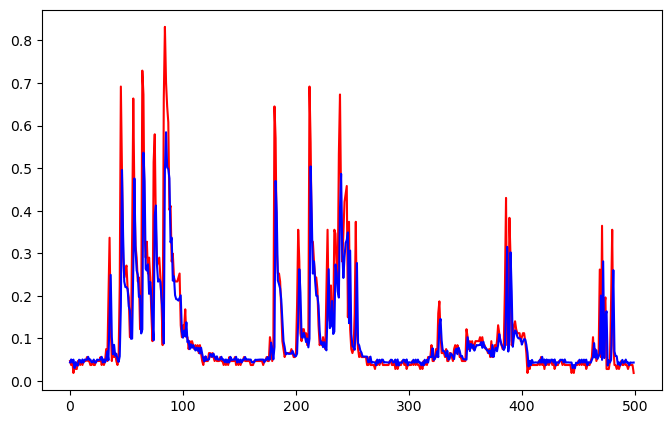

In [47]:
plt.figure(figsize=(8, 8 / 1.618));

# Just plot the first 500. There are >7k value.
plt.plot(y_test_w[:500], "r")
plt.plot(linear_support_vector_fit.predict(X_test_w[:500, :]), "b")


# Polynomial Kernel

In [48]:
params = {
    "C": 10 ** np.linspace(-3, 3, 101), 
    "epsilon": np.linspace(0, 0.1,  11),
    "degree": [2, 3, 4],
}

polynomial_support_vector_regression = SVR(
    kernel="poly", max_iter=25000, cache_size=2000
)

polynomial_svm_search = BayesSearchCV(
    polynomial_support_vector_regression,
    params, cv=TimeSeriesSplit(n_splits=5, gap=w+1),
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    n_jobs=-1, refit=True, random_state=0
)

polynomial_svm_fit = polynomial_svm_search.fit(X_train_w, y_train_w)

/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardS

In [49]:
df_html = pd.DataFrame(polynomial_svm_fit.cv_results_)
show_html(df_html.loc[:, ["params", "mean_test_score", "rank_test_score"]].sort_values(by="rank_test_score").head().to_html())

,params,mean_test_score,rank_test_score
47,"{'C': 0.0034673685045253167, 'degree': 2, 'epsilon': 0.04}",-0.004728,1
38,"{'C': 0.023988329190194897, 'degree': 2, 'epsilon': 0.04}",-0.004747,2
10,"{'C': 0.0034673685045253167, 'degree': 2, 'epsilon': 0.03}",-0.004749,3
19,"{'C': 0.0034673685045253167, 'degree': 2, 'epsilon': 0.02}",-0.004812,4
42,"{'C': 0.0034673685045253167, 'degree': 2, 'epsilon': 0.01}",-0.004984,5


# Performance Evaluation

In [50]:
poly_support_vector_mse = mean_squared_error(y_test_w, polynomial_svm_fit.predict(X_test_w))

poly_support_vector_mae = mean_absolute_error(y_test_w, polynomial_svm_fit.predict(X_test_w))

print(f"poly_support_vector_mse: {poly_support_vector_mse}.")
print(f"poly_support_vector_mae: {poly_support_vector_mae}.")

poly_support_vector_mse: 0.004270265123878355.
poly_support_vector_mae: 0.03230776246140923.


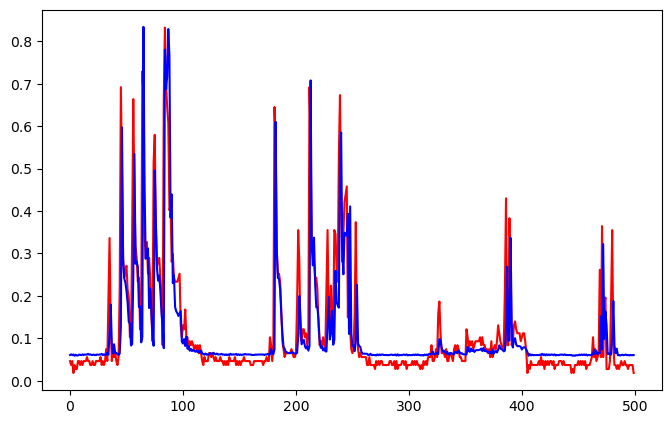

In [51]:
plt.figure(figsize=(8, 8 / 1.618));

plt.plot(y_test_w[:500], "r")
plt.plot(polynomial_svm_fit.predict(X_test_w[:500,:]), "b")


# Radial Basis Function

In [52]:
params = {
    "C": 10 ** np.linspace(-3, 3, 101),
    "epsilon": np.linspace(0, 0.1, 11), 
    "gamma": ["scale", "auto"]
}

radial_basis_function_regression = SVR(
    kernel="rbf", max_iter=25000, cache_size=2000
)

radial_basis_function_search = BayesSearchCV(
    radial_basis_function_regression, 
    search_spaces=params,
    n_iter=15, 
    cv=TimeSeriesSplit(n_splits=5, gap=w+1),
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    n_jobs=-1, refit=True, random_state=0
)

radial_basis_function_fit = radial_basis_function_search.fit(X_train_w, y_train_w)

/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/jaimemerizalde/miniconda3/envs/machineLearning/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=25000).  Consider pre-processing your data with StandardS

In [53]:
df_html = pd.DataFrame(radial_basis_function_fit.cv_results_)
show_html(df_html.loc[:, ["params", "mean_test_score", "rank_test_score"]].sort_values(by="rank_test_score").head().to_html())


,params,mean_test_score,rank_test_score
9,"{'C': 0.16595869074375597, 'epsilon': 0.04, 'gamma': 'scale'}",-0.003746,1
10,"{'C': 0.006918309709189363, 'epsilon': 0.01, 'gamma': 'scale'}",-0.003958,2
2,"{'C': 1.513561248436207, 'epsilon': 0.0, 'gamma': 'scale'}",-0.004014,3
4,"{'C': 0.023988329190194897, 'epsilon': 0.02, 'gamma': 'auto'}",-0.004078,4
7,"{'C': 1.1481536214968828, 'epsilon': 0.05, 'gamma': 'auto'}",-0.004187,5


# Performance Measures

In [54]:
rbf_mse = mean_squared_error(y_test_w, radial_basis_function_fit.predict(X_test_w))
rbf_mae = mean_absolute_error(y_test_w, radial_basis_function_fit.predict(X_test_w))

print(f"rbf_mse: {rbf_mse}")
print(f"rbf_mae: {rbf_mae}")

rbf_mse: 0.003528036731498156
rbf_mae: 0.030456354488033934


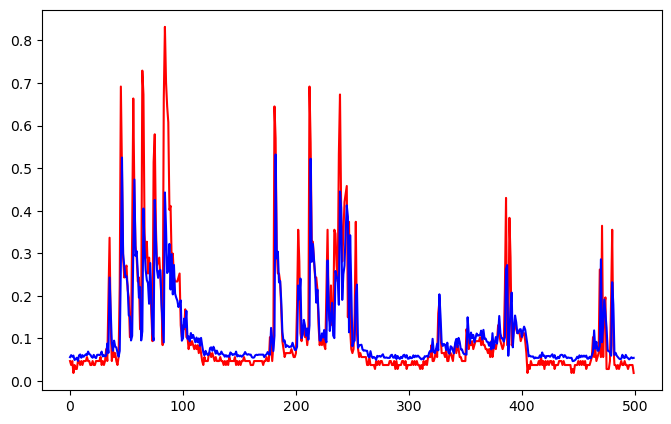

In [55]:
plt.figure(figsize=(8, 8 / 1.618))
plt.plot(y_test_w[:500], "r")
plt.plot(radial_basis_function_fit.predict(X_test_w[:500, :]), "b")